In [1]:
import numpy as np
import flopy
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import csv
import time
import seaborn as sns
sns.set_style("white")

from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm

from flopy.utils.sfroutputfile import SfrFile

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV

from treeFuncs import trainAndEvaluateModel 
from treeFuncs import metrics

modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws= "D:/mfoutput"

C:\Users\davem\anaconda3\lib\site-packages\spotpy\algorithms\padds.py:5: DeprecationWarning: Please use `ConvexHull` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import ConvexHull, QhullError
C:\Users\davem\anaconda3\lib\site-packages\spotpy\algorithms\padds.py:5: DeprecationWarning: Please use `QhullError` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import ConvexHull, QhullError


In [2]:
col_names = ['K', 'Low_K_ratio', 'Sy', 'Rech', 'ET_valley', 'ET_rip_ratio', 'Stream_K_ratio', 'Qout']
col_dict = {'K':'Base K', 'Low_K_ratio': 'Confining Layer K (as a ratio to Base K)', 'Sy':'Specific Yield', 'Rech':'Recharge', 'ET_valley':'Valley ET', 'ET_rip_ratio':'Riparian ET (as a Ratio of Valley ET)', 'Stream_K_ratio':'Streambed K'}

# load dataset
data = np.loadtxt("outputs/ModflowSfrWellOutput750Test3.txt")
#data = np.loadtxt("ModflowSfrOutput2500New.txt")

df = pd.DataFrame(data, columns = col_names)

print(df.index.shape) #how big is it 

#Set inputs and targets

X = df[col_names[:-1]] 
Y = df[col_names[-1]] #the last column in the saved csv is the flow at reach 49 - this is for ease of testing - other reaches are brought in later 


   
    

(692,)


C:\Users\davem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1036: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = self.plt.cm.get_cmap(cmap)
C:\Users\davem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1036: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = self.plt.cm.get_cmap(cmap)


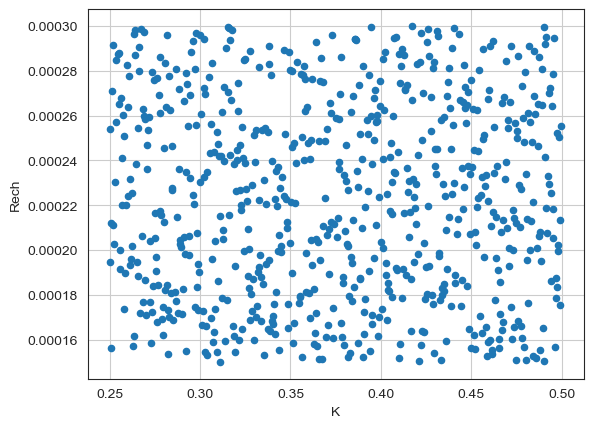

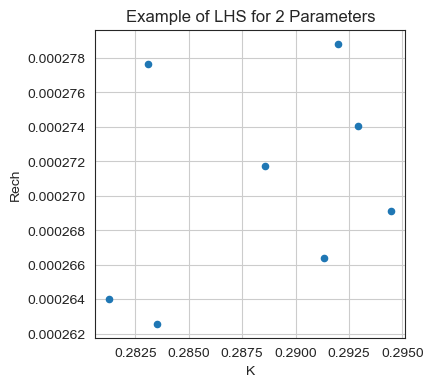

In [225]:
df.plot(kind='scatter',x ='K',y='Rech',grid = True)
sampledf = df[(df['K'] < .3) & (df['K'] > .28) & (df['Rech'] < .00028) & (df['Rech'] > .00026)]

sampledf.plot(kind='scatter',x ='K',y='Rech',grid = True, figsize=(4,4))
plt.title('Example of LHS for 2 Parameters')
plt.show()

In [69]:
#Save reach flow output as pkl
#ReachQdf.to_pickle('outputs/SS_reachQ.pkl')

8
RangeIndex(start=0, stop=692, step=1)
(306, 50)


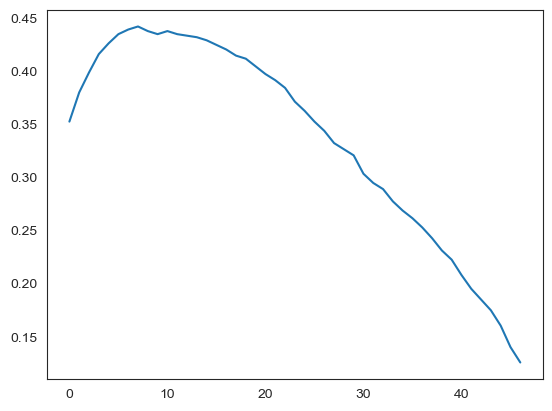

In [21]:
#Getting rid of ensembles with 0 flow
ReachQdf = pd.read_pickle('outputs/SS_reachQ.pkl')

#ReachQdf = pd.DataFrame(ReachQ)

numgrz = [len(ReachQdf[i][ReachQdf[i] > 0].index)/len(ReachQdf.index) for i in range(50)] 
print(numgrz.index(max(numgrz)))
plt.plot(numgrz[1:48])
print(ReachQdf.index)

rn_highest = numgrz.index(max(numgrz)) #find reach with greatest number of wet ensembles 
ReachQdf = ReachQdf[ReachQdf[rn_highest] > 0]

print(ReachQdf.shape)

In [ ]:
#load list of runs that did not converge so we can take those runs out
error_list = np.loadtxt("outputs/ErrorSS_SfrWell750Test3.txt")
eidx = np.array(error_list)[:,0].astype(int)
# #print(eidx)
temprange = np.arange(750)
error_free = np.delete(temprange, eidx, axis=0)

if eidx.shape[0] == 0:
    error_free = temprange #if no errors

#Sey up arrays to store reach data and budget data
ReachAqf = np.ndarray((len(error_free),50))

for j,i in enumerate(error_free):
    modelname = "/ScenarioSfrWell750Test3_"+str(i)
    sfrout = SfrFile(modws+'\\'+modelname+'.sfr.out')
    Sfrdf = sfrout.get_dataframe() 
   # print(Sfrdf.columns)
    ReachAqf[j] = Sfrdf.Qaquifer
    #plt.plot(Sfrdf.Qout[:])

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
1,0.0,-3.09780,-3.55610,-3.96670,-4.24640,-4.37870,-4.35510,-4.16610,-3.8013,-3.25530,...,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
2,0.0,-0.62715,-0.74724,-0.85518,-0.94622,-1.01830,-1.06940,-1.09800,-1.1021,-1.07990,...,0.018166,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
6,0.0,0.00000,0.00000,-0.23076,-0.45425,-0.61762,-0.72346,-0.77104,-0.7594,-0.69697,...,1.275800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
7,0.0,-11.50900,-11.09600,-11.12900,-11.18800,-11.15900,-10.99100,-10.65200,-10.1170,-9.35590,...,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
8,0.0,-1.60070,-1.92500,-2.20560,-2.41840,-2.55600,-2.61270,-2.58270,-2.4611,-2.26100,...,1.786000,2.3062,2.9288,3.6767,4.5833,5.7058,7.1588,7.0458,6.6179,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,0.0,-8.26910,-8.35190,-8.47650,-8.56960,-8.60600,-8.57100,-8.45350,-8.2437,-7.93430,...,1.614700,2.2361,2.9459,3.7754,4.7681,5.9780,7.4961,9.4260,9.2612,0.0
684,0.0,-28.33000,-26.01000,-24.94800,-24.17000,-23.40700,-22.53300,-21.47600,-20.1760,-18.48100,...,10.336000,10.9450,11.7310,12.7600,14.1410,16.1100,19.0810,24.1440,35.0190,0.0
688,0.0,0.00000,0.00000,-0.25826,-1.27320,-1.79300,-2.05500,-2.07860,-1.8749,-1.48550,...,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
689,0.0,-5.98590,-6.35980,-7.06240,-7.54810,-7.75880,-7.68320,-7.31090,-6.6270,-5.60720,...,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0


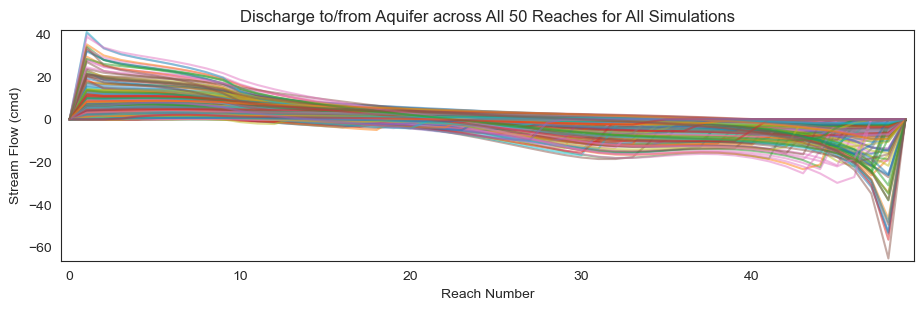

In [260]:
ReachAqfdf = pd.DataFrame(ReachAqf)
ReachAqfdf = ReachAqfdf.loc[ReachQdf.index]
display(ReachAqfdf)


plt.figure(figsize=(11,3))
for i in ReachQdf.index:
    plt.plot(ReachAqfdf.loc[i]*-1, alpha = 0.5)
    
#plt.ylim((0.01,np.max(ReachQdf)+10))
plt.ylabel('Stream Flow (cmd)')
plt.xlabel('Reach Number')
plt.title('Discharge to/from Aquifer across All 50 Reaches for All Simulations')
plt.margins(0.01)
#plt.yscale('log')
#plt.ylim((1,1000))
plt.show()


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
1,0.0,3.09780,6.6539,10.62100,14.86700,19.2460,23.6010,27.7670,31.5680,34.8230,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.0,0.62715,1.3744,2.22960,3.17580,4.1940,5.2635,6.3614,7.4635,8.5434,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.0,0.00000,0.0000,0.23076,0.68502,1.3026,2.0261,2.7971,3.5565,4.2535,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.0,11.50900,22.6050,33.73400,44.92100,56.0800,67.0710,77.7230,87.8400,97.1950,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,0.0,1.60070,3.5257,5.73130,8.14970,10.7060,13.3180,15.9010,18.3620,20.6230,...,52.006,49.70,46.771,43.094,38.511,32.805,25.646,18.601,11.983,11.983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,0.0,8.26910,16.6210,25.09800,33.66700,42.2730,50.8440,59.2980,67.5410,75.4760,...,180.530,178.30,175.350,171.580,166.810,160.830,153.330,143.910,134.650,134.650
684,0.0,28.33000,54.3400,79.28900,103.46000,126.8700,149.4000,170.8700,191.0500,209.5300,...,175.170,164.23,152.500,139.740,125.600,109.490,90.405,66.261,31.243,31.243
688,0.0,0.00000,0.0000,0.25826,1.53140,3.3244,5.3795,7.4580,9.3329,10.8180,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
689,0.0,5.98590,12.3460,19.40800,26.95600,34.7150,42.3980,49.7090,56.3360,61.9430,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


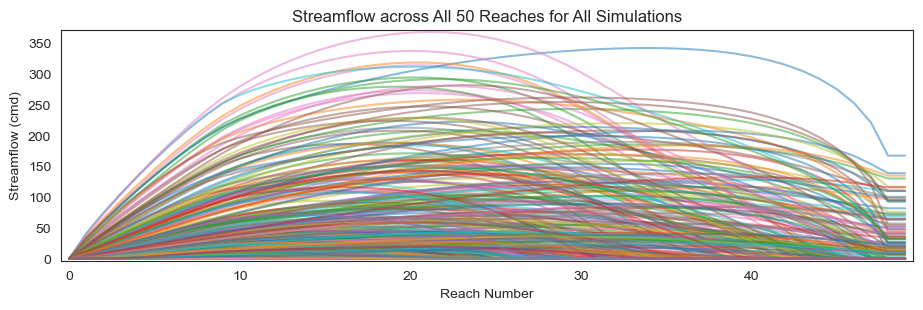

In [259]:
## Plotting out stage and depth from SFR 
display(ReachQdf)

plt.figure(figsize=(11,3))
for i in ReachQdf.index:
    plt.plot(ReachQdf.loc[i], alpha = 0.5)
    
#plt.ylim((0.01,np.max(ReachQdf)+10))
plt.ylabel('Streamflow (cmd)')
plt.xlabel('Reach Number')
plt.title('Streamflow across All 50 Reaches for All Simulations')
plt.margins(0.01)
#plt.yscale('log')
#plt.ylim((1,1000))
plt.show()


# print(stage[:][25].mean(),stage[:][25].max(),stage[:][25].min())
# print(depth[:][25].mean(),depth[:][25].max(),depth[:][25].min())
# plt.figure(figsize=(8,5))
# for i in range(len(error_free)):
#     plt.plot(stage[i])
# plt.show()

# plt.figure(figsize=(8,5))
# for i in range(len(error_free)):
#     plt.plot(depth[i])
# plt.show()
# for i in range(len(error_free)):
#     plt.plot(cond[i])
# plt.show()

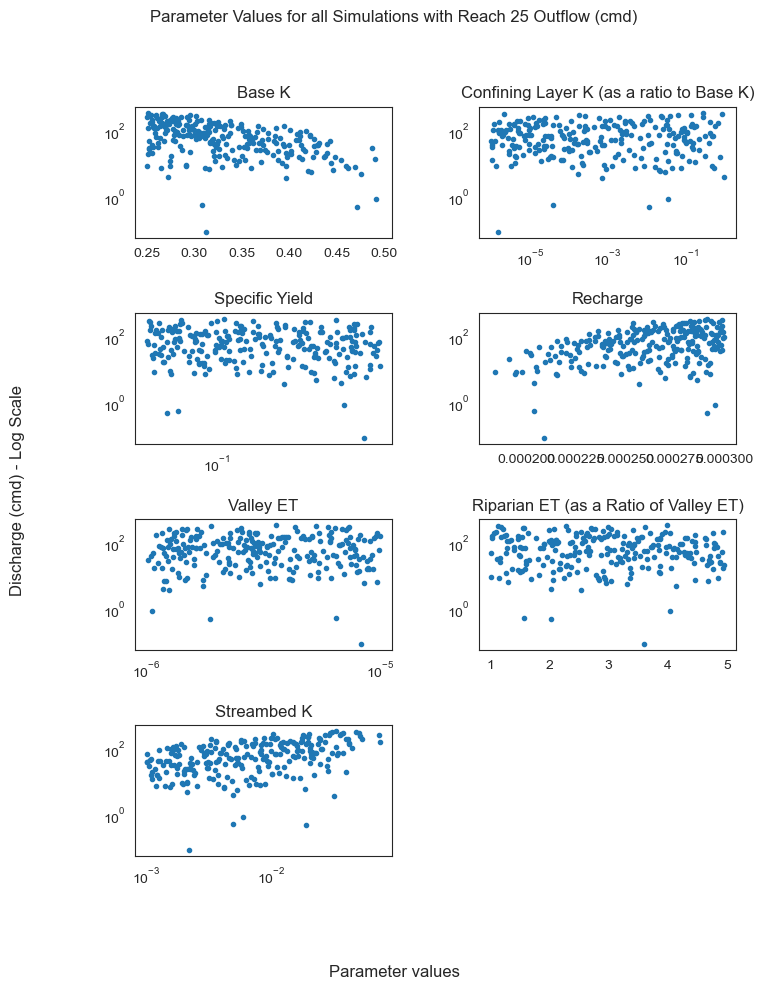

In [72]:
#Plot out the parameters per ensemble discharge at reach 25

#Uncomment line below if pulling from pkl file
#ReachQdf = pd.read_pickle('outputs/SS_reachQ.pkl')
params = X.loc[ReachQdf.index]


fig, axs = plt.subplots(4, 2, sharex=False, sharey=False,figsize=(8, 10))
fig.suptitle('Parameter Values for all Simulations with Reach 25 Outflow (cmd)')
fig.supylabel('Discharge (cmd) - Log Scale')
fig.supxlabel('Parameter values')
fig.tight_layout(pad = 3.5)
fig.delaxes(axs[3,1])
# for i in range(len(col_names) - 1):
#     axs.plot(X[col_names[i]],Y,'k.')
i=0
logpars = [1,2,4,6]
for row in axs:
    for col in row: 
        col.plot(params[col_names[i]],ReachQdf[25],'.')
        col.title.set_text(col_dict[col_names[i]])
        if i in logpars:
            col.set_xscale('log')
        col.set_yscale('log')
        if i < (len(col_names)-2):
            i+=1
        else:
            break

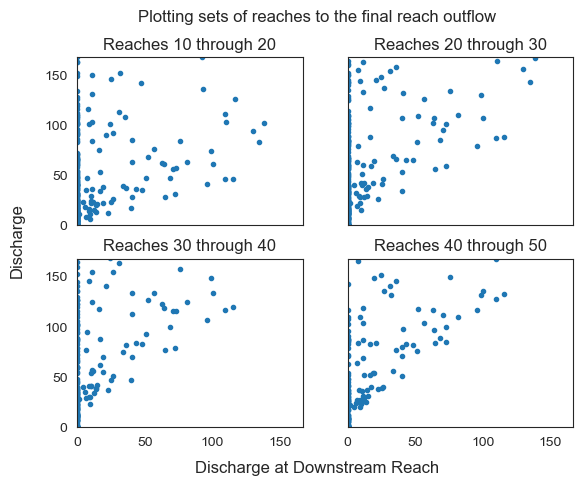

Text(0.5, 0, 'Reach Number')

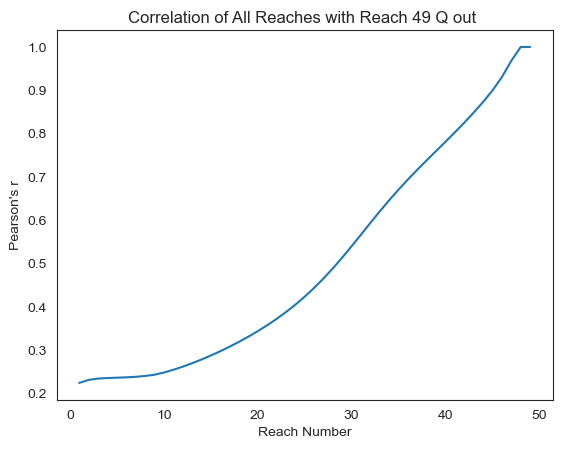

In [74]:
## PLotting out Correlations of reach flows
##examine flows for every reach compared to ds most reach (49)

#print(ReachQdf.head())
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle('Plotting sets of reaches to the final reach outflow')
fig.supylabel('Discharge')
fig.supxlabel('Discharge at Downstream Reach')

k=10
for row in axs:
    for col in row:        
        for i in range(k,k+10,10):
            col.plot(ReachQdf[49],ReachQdf[i], '.')
            col.title.set_text('Reaches ' +str(k) +' through ' +str(k+10))
        k+=10

plt.xlim(0,int(ReachQdf[49].max()))
plt.ylim(0,int(ReachQdf[49].max()))
plt.show()

    
ReachQdf.corrwith(ReachQdf[49]).plot()
plt.title('Correlation of All Reaches with Reach 49 Q out ')
plt.ylabel('Pearson\'s r')
plt.xlabel('Reach Number')

## Now for the Modflow Cell Heads

In [19]:
ibound = np.loadtxt('base/ibound_lyr1.txt')            
all_well_loc = np.asarray(np.where(ibound == 1)).T
print(all_well_loc) #nrow,ncol

[[ 1  5]
 [ 1  6]
 [ 1  7]
 ...
 [48 16]
 [48 17]
 [48 18]]


In [76]:
#Get Head data for All active wells

#load in Ibound and find active cells in model - then put it into a list of well locations

# 
#error_free = b
#error_free = X2.index
#error_free = np.delete(temprange, eidx, axis=0)

well_head = np.empty((len(error_free),all_well_loc.shape[0]))
well_error_sim = []
#well_error_num = []
for j, i in enumerate(error_free):
#for j, i in enumerate(df_flow.index):
    modelname = "ScenarioSfrWell750Test3_"+str(i)
    headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
    head = headobj.get_alldata(nodata=0)#-9.9998999e+02)
    for k in range(all_well_loc.shape[0]):        
        h = head[0][0][int(all_well_loc[k][0])][int(all_well_loc[k][1])]        #ntime, nlay, nrow, ncol
        if h < -1e10: #really low values for dry cells are throwing off the std deviations so adjusted it to btm of layer 0
            h = 0 #bottom of first layer
        
        well_head[j][k] = h
        #if (well_head[k][j] < 0) or (well_head[k][j] > 200) or np.isnan(well_head[k][j]):
        if (well_head[j][k] > 200) or np.isnan(well_head[j][k]):
            well_error_sim.append(i)
## Delete out simulations where well head is twice the average

new_zone = X.loc[~X.index.isin(np.unique(well_error_sim))]
#new_zone.head
well_head_df = pd.DataFrame(well_head, index = X.index)
well_head_df = well_head_df.loc[new_zone.index]
# new_well_head = np.delete(well_head, well_error_num, 1)

print(len(well_head_df.index))

# Split dataset into training set and test set, default here is 30% test
test = X.loc[well_head_df.index]
test_q = Y.loc[well_head_df.index]

#well_head_df.to_pickle('WellHead_SS.pkl')


NameError: name 'error_free' is not defined

In [22]:
#if not pulling new heads
well_head_df = pd.read_pickle('outputs/heads/WellHead_SS.pkl')

#use only simulations that are similar to ReachQdf - or in this case > 0 at reach 25
well_head_df = well_head_df.loc[ReachQdf.index]


In [23]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import wellmesh_correlation


wellmesh_corr = wellmesh_correlation(all_well_loc,well_head_df)

well num, well col, well row 

844 21 31
1      76.706337
2      74.173676
6      78.590317
7      75.917862
8      80.883102
         ...    
682    84.110527
684    80.624893
688    78.400429
689    74.184364
690    83.378723
Name: 844, Length: 306, dtype: float64


C:\Users\davem\AppData\Local\Temp\ipykernel_11732\2830844364.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=30)


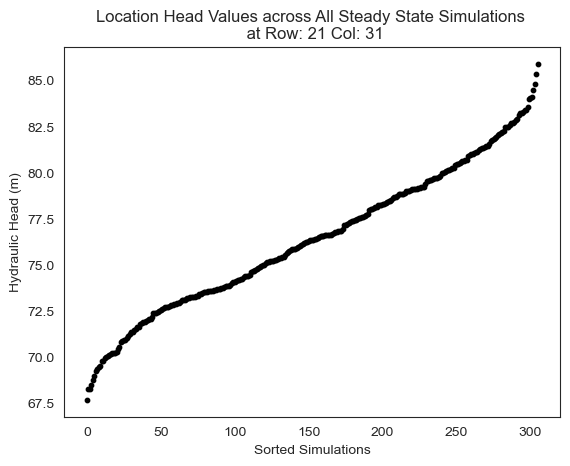

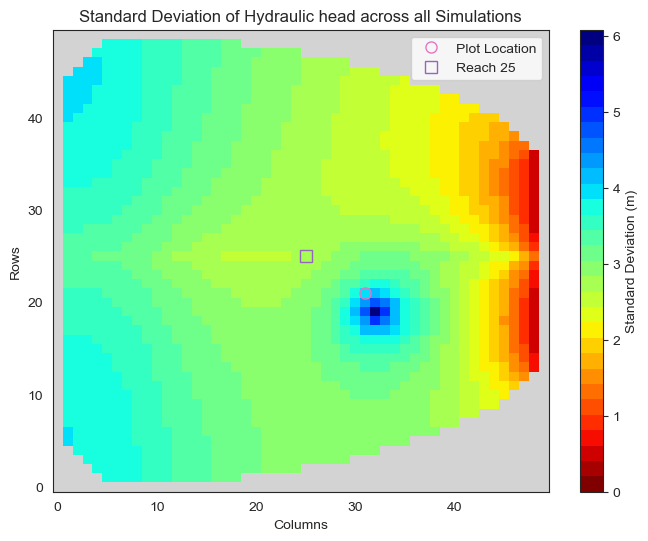

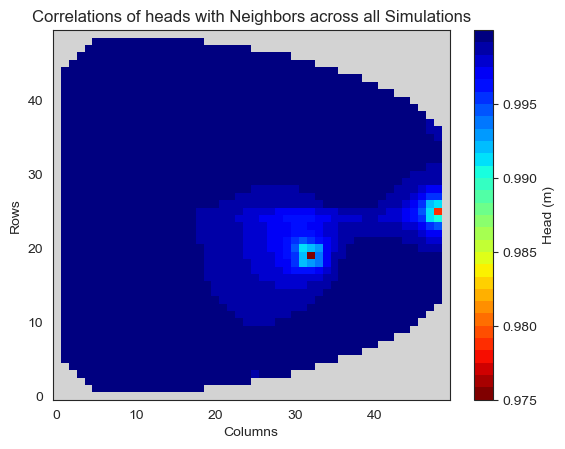

In [24]:
wn = 844
print("well num, well col, well row \n")
print(wn,int(all_well_loc[wn][0]), int(all_well_loc[wn][1]))
print(well_head_df[wn])

plt.scatter(range(len(well_head_df[wn].index)),well_head_df[wn].sort_values(), s = 10, c='k')
plt.xlabel('Sorted Simulations')
plt.ylabel('Hydraulic Head (m)')
plt.title("Location Head Values across All Steady State Simulations \n at Row: " +str(all_well_loc[wn][0])+ " Col: " + str(all_well_loc[wn][1]))
ztop = np.genfromtxt('base/base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)


kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

# print(well_head_var)
wellmesh = np.ndarray((50,50))
wellmesh[:][:] = -1e30

wellmesh2 = wellmesh.copy()
#well_head_df[1060].plot()
#print(int(all_well_loc[wn, 0]),int(all_well_loc[wn, 1]))
for i in range(all_well_loc.shape[0]):
    wellmesh[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = well_head_df[i].std()
    wellmesh2[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = well_head_df[i].mean() - ztop[int(all_well_loc[i, 0]),int(all_well_loc[i, 1])]
#print(well_head_df[wn].std())
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
cmap2 = cm.get_cmap("jet_r",lut=30)
cmap2.set_under("lightgray")
river = np.ndarray((48,))
river[:] = 25
plt.figure(figsize=(8,6))

plt.pcolormesh(KK,GG,wellmesh,cmap = cmap2, vmin = 0,shading='nearest')
plt.colorbar(label = 'Standard Deviation (m)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="tab:pink", mfc='none', linestyle = "None", label="Plot Location")
#plt.plot(range(1,49),river, color="lightblue",label='River')
plt.plot(25,25, marker="s", markersize=8, color="tab:purple", mfc='none', linestyle = "None", label="Reach 25")


plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Standard Deviation of Hydraulic head across all Simulations')
plt.legend()
plt.show()

# plt.figure(figsize=(8,6))

# plt.pcolormesh(KK,GG,wellmesh2,cmap = cmap2, vmin = -25, shading='nearest')
# plt.colorbar(label = 'Head (m)')
# plt.plot(int(all_well_loc[wn][0]), int(all_well_loc[wn][1]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Example Location")
# plt.xlabel('Columns')
# plt.ylabel('Rows')
# plt.title('Average head across all Simulations')
# plt.show()

# plt.figure(figsize=(8,6))

plt.pcolormesh(KK,GG,wellmesh_corr,cmap = cmap2, vmin=0.975, shading='nearest')
plt.colorbar(label = 'Head (m)')
#plt.plot(int(all_well_loc[wn][0]), int(all_well_loc[wn][1]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Example Location")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Correlations of heads with Neighbors across all Simulations')
plt.show()
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')

#plt.imshow(wellmesh, cmap='RdBu')


## Using Heads to predict stream Flow

In [25]:
## Setting up the head inputs

river_well_loc = np.where(all_well_loc[:,0] == 25)
#river_well_loc = np.where((all_well_loc[:,0] > 23) & (all_well_loc[:,0] < 27))

CHBound_loc = np.where(all_well_loc[:,1] > 47) #
drop_locs= np.concatenate((river_well_loc, CHBound_loc), axis = 1)
#print(len(river_well_loc[0]))
well_head_noRiv = well_head_df.drop(drop_locs[0], axis = 1)
#well_head_noRiv = well_head_noRiv.drop(CHBound_loc[0], axis = 1)
#print(well_head_noRiv.shape)
new_zone_q = ReachQdf.loc[well_head_noRiv.index]

well_head_noRiv.columns = well_head_noRiv.columns.astype(str)

well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])
print(well_head_noRiv.shape)
#Normalizing inputs (?) - not currently using 
# norm_well_df = (well_head_noRiv - np.min(well_head_noRiv.min().values))
# norm_well_df = norm_well_df/ np.max(well_head_noRiv.max().values)
# norm_well_df.columns = norm_well_df.columns.astype(str)

(306, 1941)


In [86]:
#Finding the hyperparameters

#reach number to use 
rn = 25
print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn] > 0].index) / len(new_zone_q.index)))

X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.2)

#split quality function
split_criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
#Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(3,10)] #14 was the max depth, 3 or greater is recommened, 8 seems high enough 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
#maximum 
max_leaf_nodes = [int(x) for x in range(int(np.max(y_train)**(1/2)),int(np.max(y_train)),int(np.max(y_train)/10))]
max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

splitter = ['best']
# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                'criterion' : split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease,
                'splitter': splitter}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
dtr = DecisionTreeRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dtr_random = RandomizedSearchCV(estimator = dtr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
dtr_random.fit(X_train, y_train)
best_pars_dt = dtr_random.best_params_
print(best_pars_dt)

from sklearn.tree import plot_tree


best_random = dtr_random.best_estimator_
y_pred = best_random.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_pred, y_test))
print("KGE: ", kge(y_test, y_pred))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_test)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

# _, ax = plt.subplots(figsize=(25, 25))
# _ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

Fraction of wet simulations: 0.803921568627451
{'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 5, 10, 15], 'min_samples_leaf': [1, 2, 5, 10], 'max_leaf_nodes': [18, 53, 88, 123, 158, 193, 228, 263, 298, 333, None], 'min_impurity_decrease': [5, 15, 25, 35, 45], 'splitter': ['best']}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

## Tree using Wells to predict Qout

In [87]:
#Best pars from above saved here as a dictionary - only run this if skipping hyperparameter search
best_pars_dt = {'splitter': 'best', 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 35, 'max_leaf_nodes': 263, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}

Shape of Input Samples: (306, 1941)
Total time: 44.0810866355896


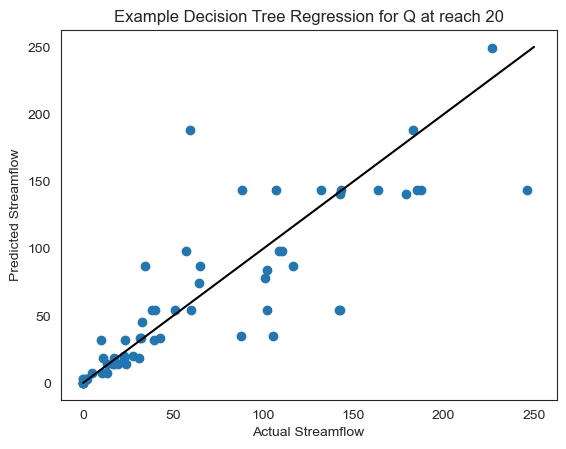

bias     0.386676
rmse    39.471116
r        0.862266
nse      0.715073
kge      0.807833
dtype: float64


In [88]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 100

PredList = []
NSEList = []
metric_ls = []
importanceList = []
depthlist = []



#new_zone_q = np.log(ReachQdf.loc[well_head_noRiv.index]+1)
new_zone_q = ReachQdf.loc[well_head_noRiv.index]
rn = 20


imp_df, metrics_df, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, well_head_noRiv, new_zone_q, best_pars_dt, 0.2, n, rn)  

print('Total time: ' + str(time.time()-t0))

plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Example Decision Tree Regression for Q at reach " + str(rn)
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

print(metrics_df)

[0.591043923250328, 0.10154127368846871, 0.07003014945526526]


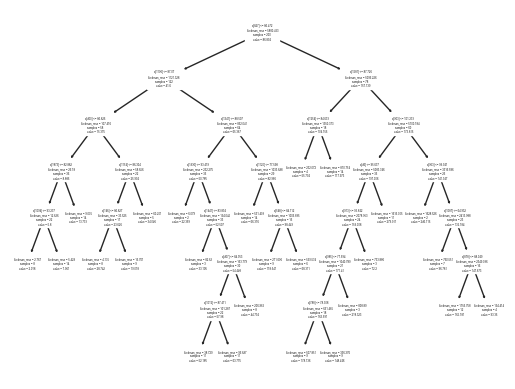

In [46]:
# tree.plot_tree(Tree)
# print(sorted(Tree.feature_importances_, reverse=True)[:3])

In [ ]:
# print(well_head_df.mean())
# norm_well_df = (well_head_df - np.min(well_head_df.min().values))
# norm_well_df = norm_well_df/ np.max(norm_well_df.max().values)
# print(np.min(norm_well_df))
#plt.scatter(range(2012),norm_well_df.var().values)
# well = '1017'
# print(Tree.feature_importances_)
# plt.scatter(well_head_df[well],ReachQdf[well])

#imp_df.sum(axis = 1).plot(kind="bar")

In [71]:
# #imp_df.to_pickle('SteadyState_DT_Impdf.pkl')


# test = pd.DataFrame(y_test)
# test['pred'] = y_pred
# test = test[test[25] > 0]
# #print(test)
# plt.scatter(test[25], test['pred'])

# print(NSE(test[25], test['pred']))
# print(kge(test[25], test['pred']))
# print(test.corrwith(test['pred']))

# plt.figure()
# plt.scatter(y_test, y_pred)
# outmax = np.max(y_pred) +10
# plt.plot([0, 1], [0, 1], color='k', linestyle='-')

# plt.xlabel("Actual Streamflow")
# plt.ylabel("Predicted Streamflow")
# title = "Decision Tree Regression for Q at reach " + str(rn) +" - NSE: " + str(round(NSEList[-1],2))
# plt.title(title)
# plt.ylim((0,10))
# plt.xlim((0,10))
# # plt.yscale('log')
# # plt.xscale('log')
# #plt.legend()
# plt.show()

Shape of Input Samples: (306, 1941)
Total time: 9.341722965240479
Fraction of wet simulations: 0.8954248366013072
bias     0.849843
rmse    47.459706
r        0.800773
nse      0.608998
kge      0.746365
dtype: float64


Text(0.5, 1.0, 'Example Random Decision Tree Regression for Q at reach 20')

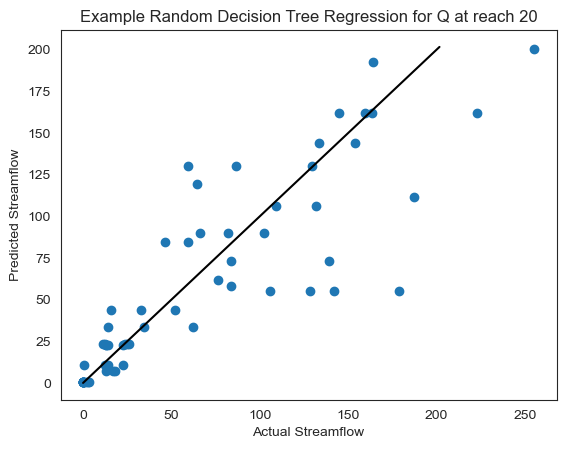

In [93]:
# RANDOM Tree 
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 100

#Splitter is random and max features is set to 1, note that 1.0 is all in the new Sklearn so this is a little confusing
best_pars_dt_rand = {'splitter': 'best', 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 35, 'max_leaf_nodes': 263, 'max_features': 1, 'max_depth': 7, 'criterion': 'friedman_mse'}
    
imp_df_rand, metrics_df_rand, y_test, y_pred = trainAndEvaluateModel(ExtraTreeRegressor, well_head_noRiv, new_zone_q, best_pars_dt_rand, 0.2, n, rn)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_rand)
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Example Random Decision Tree Regression for Q at reach " + str(rn)
plt.title(title)

[   0    1    2 ... 2009 2010 2011]
Number of Features used in Stress period 0: 1941
Sum of Importances in Stress period 0: 1.0


C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


[   0    1    2 ... 2009 2010 2011]
Number of Features used in Stress period 0: 1941
Sum of Importances in Stress period 0: 0.9999999999999999


C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


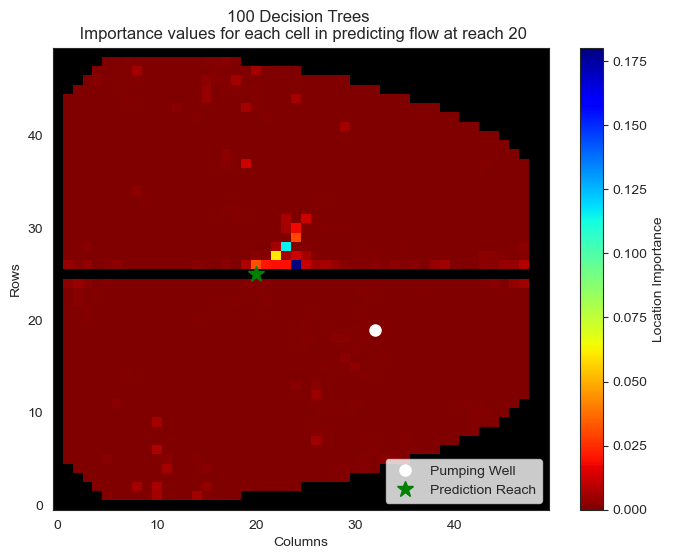

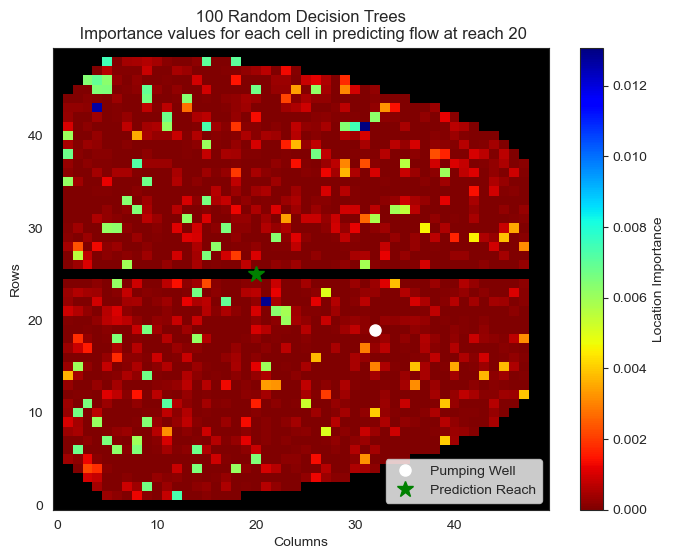

In [106]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import plotImportance

numTS = 1
n = 100

title = '100 Decision Trees \n Importance values for each cell in predicting flow at reach ' + str(rn)

wellmesh_df = plotImportance(imp_df,well_head_noRiv, well_loc_df,numTS,n,rn,title)

title_rand = ' 100 Random Decision Trees \n Importance values for each cell in predicting flow at reach ' + str(rn)

wellmesh_rand = plotImportance(imp_df_rand,well_head_noRiv, well_loc_df,numTS,n,rn,title_rand)


In [51]:
mostImportant = dt_total_imp_df.sort_values(ascending=False)[:5]
print(len(mostImportant.index))
print(mostImportant)

5
1269    0.044159
1366    0.038672
1076    0.025612
1318    0.025386
1075    0.020955
dtype: float64


Average NSE:  0.788361642040695


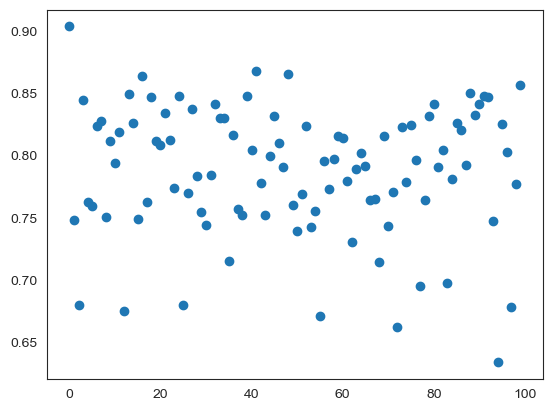

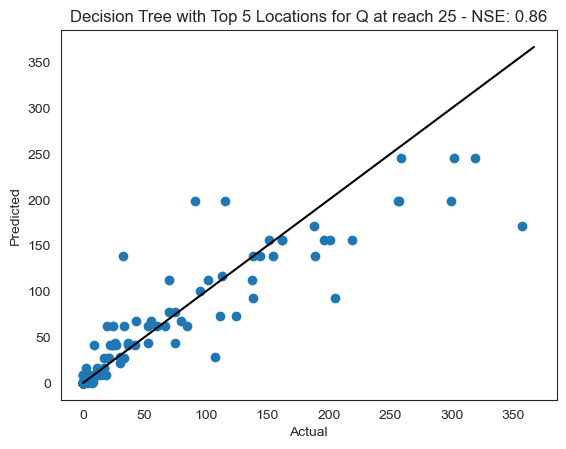

Total time: 2.042459487915039


In [21]:
# ONly using the most important cells for the decision tree 
t0 = time.time()
n = 100

PredList = []
NSEList = []
importanceList = []

#new_zone_q = ReachQdf.loc[well_head_noRiv.index]
mostImpWellHead = well_head_df.loc[:,mostImportant.index]

for i in range(n):
    well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(mostImpWellHead, new_zone_q[rn], test_size=0.3) #random_state=1)
    # Create Random Forest Object
    Tree = DecisionTreeRegressor(**best_pars_dt
    #max_depth = 2 {'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
    )

    # Train Decision Tree Classifer
    Tree = Tree.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = Tree.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test))
    #feature importance
    importanceList.append(Tree.feature_importances_)
   
    
    
#well head Tree NSE
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", np.mean(NSEList))
plt.scatter(range(n),NSEList)
#print(PredList[99])
plt.figure()
#for i in range(1):
plt.scatter(y_test, y_pred)
outmax = np.max(y_test) + 10
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Decision Tree with Top 5 Locations for Q at reach " + str(rn) +" - NSE: " + str(round(NSEList[-1],2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

Fraction of wet simulations: 0.434971098265896


<Axes: >

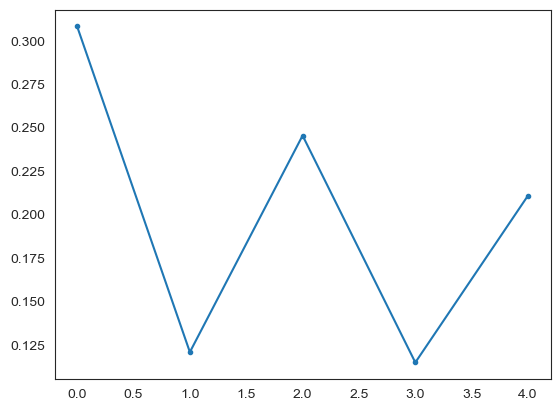

In [22]:
print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[10] > 0].index) / len(new_zone_q.index)))

WellStreamimportance = Tree.feature_importances_

miimportance_df = pd.DataFrame(importanceList).sum()/100

miimportance_df.plot(marker='.')

In [24]:
#feature importance Mapping
miwellmesh = np.ndarray((50,50))
miwellmesh[:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, river_well_loc[0], axis = 0)
#for i in range(all_well_loc.shape[0]):
for i,k in enumerate(mostImportant.index):
    #if(all_well_loc[i,1] != 25):
    miwellmesh[int(well_loc_df.loc[k, 1]), int(well_loc_df.loc[k, 0])] = miimportance_df[i] #np.sum(importanceList[:,i])  
print(miimportance_df)
print(mostImportant.index)

0    0.308184
1    0.120753
2    0.245395
3    0.114780
4    0.210889
dtype: float64
Int64Index([1076, 1366, 1126, 1127, 1124], dtype='int64')


C:\Users\davem\AppData\Local\Temp\ipykernel_10576\3800517588.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=10)


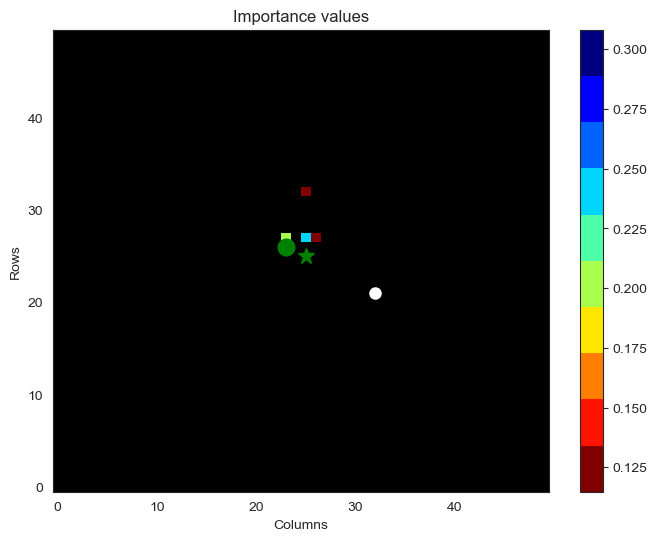

1076 23 26


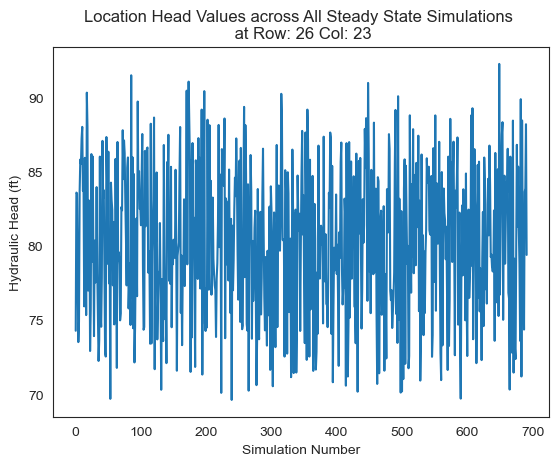

In [32]:
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
#PLotting out the result grid

cmap2 = cm.get_cmap("jet_r",lut=10)
cmap2.set_under("k")

vmax = np.max(miimportance_df)
#vmax = 1
vmin = np.min(miimportance_df)

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,miwellmesh,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")
plt.plot(int(well_loc_df.loc[wn, 1]),int(well_loc_df.loc[wn, 0]),marker="o", markersize=12, color="white", linestyle = "None",label="Most Important Loc")

# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar()
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Importance values')
plt.show()
wn = 1076
#int(well_loc_df.loc[wn, 1]), int(well_loc_df.loc[wn, 0])
print(wn,int(well_loc_df.loc[wn, 1]), int(well_loc_df.loc[wn, 0]))
well_head_df[wn].plot()
plt.xlabel('Simulation Number')
plt.ylabel('Hydraulic Head (ft)')
plt.title("Location Head Values across All Steady State Simulations \n at Row: " +str(well_loc_df.loc[wn, 0])+ " Col: " + str(well_loc_df.loc[wn, 1]))
plt.show()


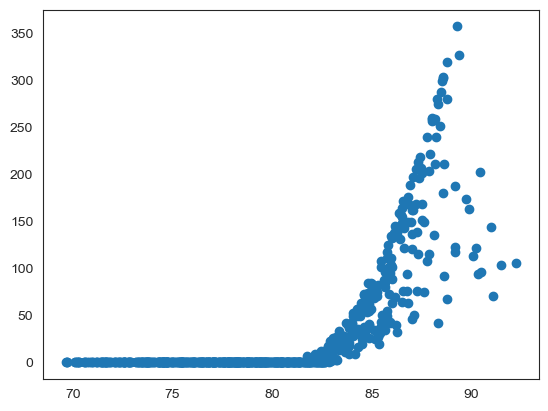

In [33]:

plt.scatter(well_head_df[wn],ReachQdf[rn])

In [34]:
# print(result.importances_mean)

# wellmesh = np.ndarray((50,50))
# wellmesh[:,:] = -1e30

# for i in range(all_well_loc.shape[0]):
#     wellmesh[int(all_well_loc[i, 1]), int(all_well_loc[i, 0])] = result.importances_mean[i] #np.sum(importanceList[:,i])

# #wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
# cmap2 = cm.get_cmap("jet_r",lut=10)
# cmap2.set_under("k")

# vmax = np.max(0.001)
# vmin = np.min(WellStreamimportance)

# plt.figure(figsize=(8,6))
# plt.pcolormesh(KK,GG,wellmesh,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
# # grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
# #plt.show()
# #plt.imshow(wellmesh, cmap='RdBu')
# plt.colorbar()
# plt.xlabel('Columns')
# plt.ylabel('Rows')
# plt.title('Permutation Importance values')

## Gradient Boosting

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])
{'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [25, 75, 125, 175, 225], 'criterion': ['squared_error', 'friedman_mse'], 'max_features': [1.0, 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_leaf_nodes': [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None, None], 'min_impurity_decrease': [5, 15, 25, 35, 45]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'subsample': 0.6, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease':

C:\Users\davem\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


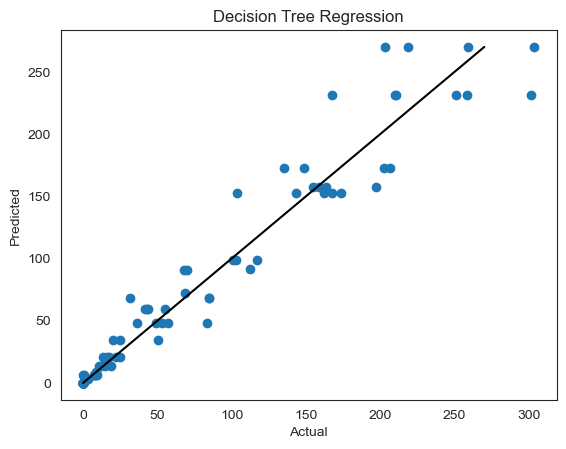

In [36]:
new_zone_q = ReachQdf.loc[well_head_noRiv.index]
rn =25
print(GradientBoostingRegressor().get_params().keys())
#choosing one well and finding the hyperparameters that best work for it 
rand_reach = np.random.randint(low=1,high=48)
#print(rand_well)
X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.2)
loss = ['squared_error', 'absolute_error', 'huber', 'quantile']
n_estimators = [int(x) for x in range(25,275,50)]
subsample = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]             
#split quality function
split_criterion = ['squared_error', 'friedman_mse']
splitter = ['best']
#Number of features to consider at every split
max_features = [1.0, 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(3,10)] #14 was the max depth, 3 is recommened, 10 seems high enough 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#maximum 
max_leaf_nodes = [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None]#[int(x) for x in range(int(np.max(y_train)**(1/2)),int(np.max(y_train)),int(np.max(y_train)/10))]
max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                'loss' : loss,
                'subsample':subsample,
                'n_estimators':n_estimators,
                'criterion' : split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgr = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgr_random = RandomizedSearchCV(estimator = xgr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgr_random.fit(X_train, y_train)
best_pars_gr = xgr_random.best_params_
print(best_pars_gr)

#from sklearn.tree import plot_tree


best_random_gr = xgr_random.best_estimator_
y_pred = best_random.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_pred, y_test))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

#_, ax = plt.subplots(figsize=(25, 25))
#_ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

In [60]:
best_pars_gr = {'subsample': 0.6, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 45, 'max_leaf_nodes': 52, 'max_features': 'll', 'max_depth': 3, 'loss': 'squared_error', 'criterion': 'friedman_mse'}

Shape of Input Samples: (306, 1941)
Total time: 1.336416244506836


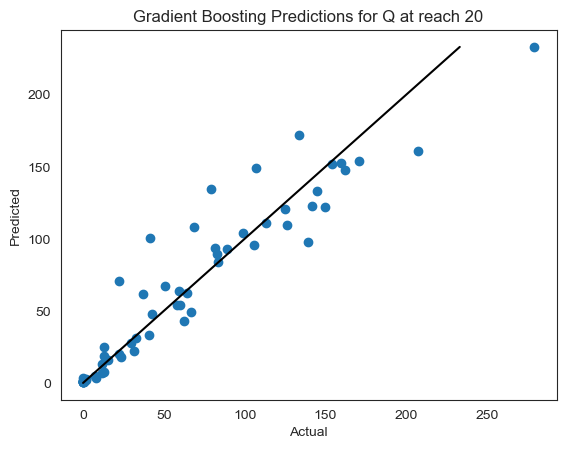

bias    -0.542726
rmse    19.792207
r        0.948713
nse      0.899555
kge      0.911218
dtype: float64


In [95]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1

gr_imp_df, metrics_df_gr, y_test, y_pred = trainAndEvaluateModel(GradientBoostingRegressor, well_head_noRiv, new_zone_q, best_pars_gr, 0.2, n, rn)  


t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Gradient Boosting Predictions for Q at reach " + str(rn)
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()
print(metrics_df_gr)

[   0    1    2 ... 2009 2010 2011]
Number of Features used in Stress period 0: 1941
Sum of Importances in Stress period 0: 0.9999999999999999


C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


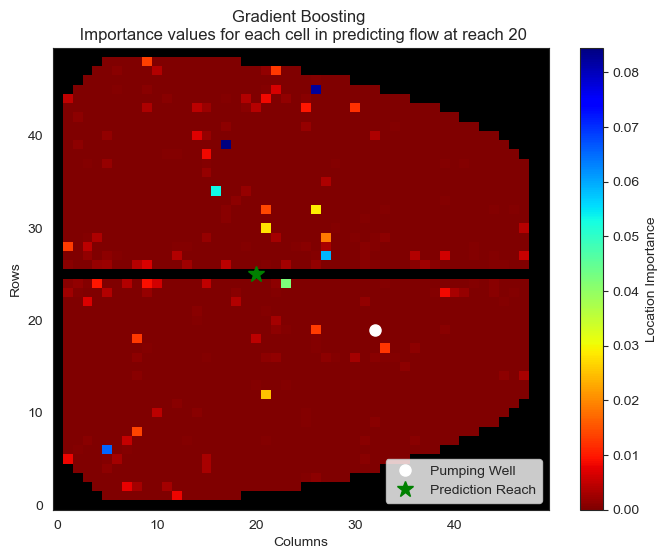

In [110]:
n=1
title_gr = 'Gradient Boosting \n Importance values for each cell in predicting flow at reach ' + str(rn)
wellmesh_gr = plotImportance(gr_imp_df,well_head_noRiv, well_loc_df,numTS,n,rn,title_gr)

## Random Forest - Steady State

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
{'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [25, 75, 125, 175, 225], 'criterion': ['squared_error', 'friedman_mse'], 'max_features': [1.0, 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5, 10], 'max_leaf_nodes': [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None], 'min_impurity_decrease': [5, 15, 25, 35, 45]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}
RMSE:  14.323115946437962


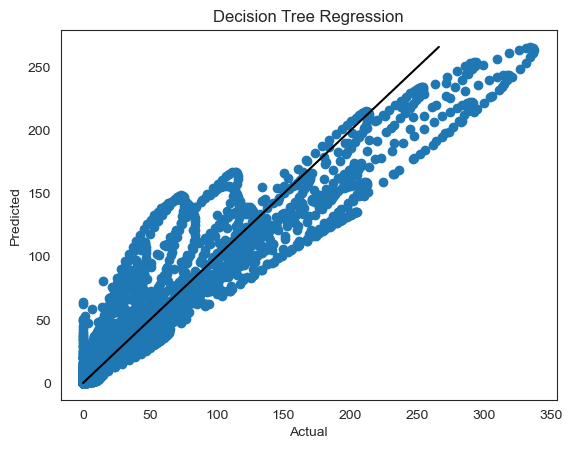

In [73]:
from sklearn.ensemble import RandomForestRegressor
rn = 25
# X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.3)#, random_state=1) #changed the random state to 1 - 2/27/23
#     # Create Random Forest Object

# #X_train, X_test, y_train, y_test = train_test_split(well_sample, test_q, test_size=0.3, random_state=0)

# RF = RandomForestRegressor(
# #max_depth = 2
# # n_estimators= 400,
# # min_samples_split = 2,
# # min_samples_leaf= 4,
# # max_features= 'sqrt',
# # max_depth= 10, 
# # bootstrap= True
    
# )#default Hyperparameters

# #print(RF.get_params())
new_zone_q = ReachQdf.loc[well_head_noRiv.index]

print(RandomForestRegressor().get_params().keys())
#choosing one well and finding the hyperparameters that best work for it 
rand_reach = np.random.randint(low=1,high=48)
#print(rand_well)
X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.2)
n_estimators = [int(x) for x in range(25,275,50)]
max_sample = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]             
#split quality function
split_criterion = ['squared_error', 'friedman_mse']
#splitter = ['best']
bootstrap = ['True']
#Number of features to consider at every split
max_features = [1.0, 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(3,10)] #14 was the max depth, 3 is recommened, 10 seems high enough 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
#maximum 
max_leaf_nodes = [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None]#[int(x) for x in range(int(np.max(y_train)**(1/2)),int(np.max(y_train)),int(np.max(y_train)/10))]
#max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                #'bootstrap' : bootstrap,
                'max_samples':max_sample,
                'n_estimators':n_estimators,
                'criterion' : split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfr_random = RandomizedSearchCV(estimator = rfr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rfr_random.fit(X_train, y_train)
best_pars_rf = rfr_random.best_params_
print(best_pars_rf)

#from sklearn.tree import plot_tree


best_random_rf = rfr_random.best_estimator_
y_pred = best_random_rf.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
#print("NSE: ", NSE(y_pred, y_test))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

#_, ax = plt.subplots(figsize=(25, 25))
#_ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

In [99]:
best_pars_rf = {'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}

Shape of Input Samples: (306, 1941)
Total time: 65.1125648021698


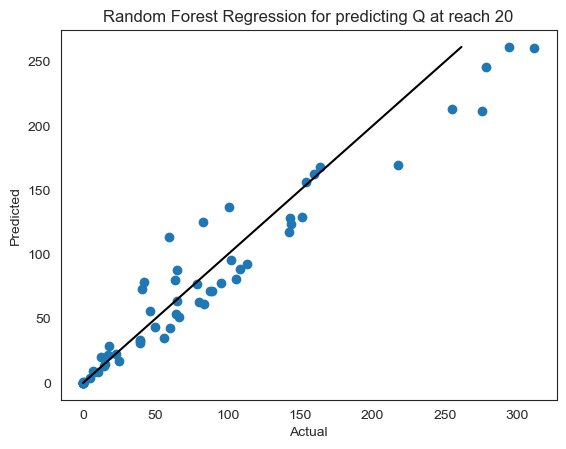

bias     5.386437
rmse    21.518831
r        0.971101
nse      0.927688
kge      0.847022
dtype: float64


In [101]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1

    
rf_imp_df, metrics_df_rf, y_test, y_pred = trainAndEvaluateModel(RandomForestRegressor, well_head_noRiv, new_zone_q, best_pars_rf, 0.2, n, rn)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Random Forest Regression for predicting Q at reach " + str(rn) 
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()
print(metrics_df_rf)

[   0    1    2 ... 2009 2010 2011]
Number of Features used in Stress period 0: 1941
Sum of Importances in Stress period 0: 0.9999999999999999


C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


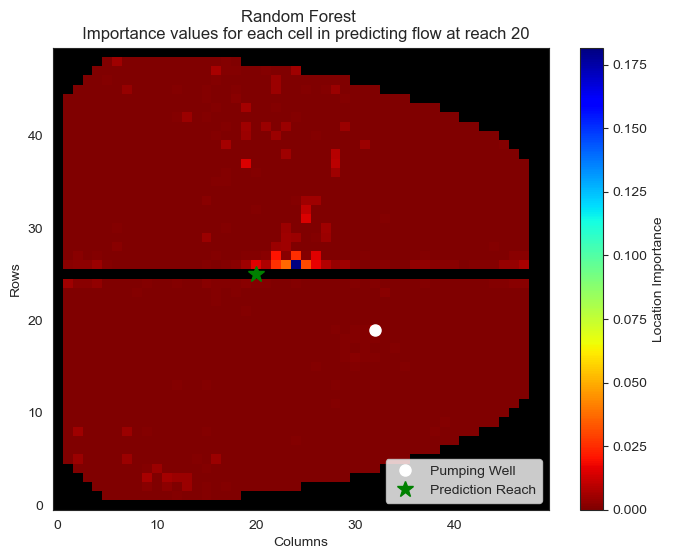

In [111]:
title_rf = 'Random Forest \n  Importance values for each cell in predicting flow at reach ' + str(rn)
wellmesh_rf = plotImportance(rf_imp_df,well_head_noRiv, well_loc_df,numTS,n,rn,title_rf)

[[0.96862745 0.98823529 0.96078431 1.        ]
 [0.96419839 0.98651288 0.95561707 1.        ]
 [0.95976932 0.98479047 0.95044983 1.        ]
 ...
 [0.43443291 0.00738178 0.05491734 1.        ]
 [0.41917724 0.00369089 0.05294887 1.        ]
 [0.40392157 0.         0.05098039 1.        ]]


C:\Users\davem\AppData\Local\Temp\ipykernel_12168\404704904.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_bd = cm.get_cmap("gray")#,lut=20)


[Text(0.0, 0, ''),
 Text(0.1, 0, 'Random Forest'),
 Text(0.35, 0, 'Gradient Boosted'),
 Text(0.6, 0, 'Decision Tree'),
 Text(0.85, 0, 'Random Tree'),
 Text(1.0, 0, '')]

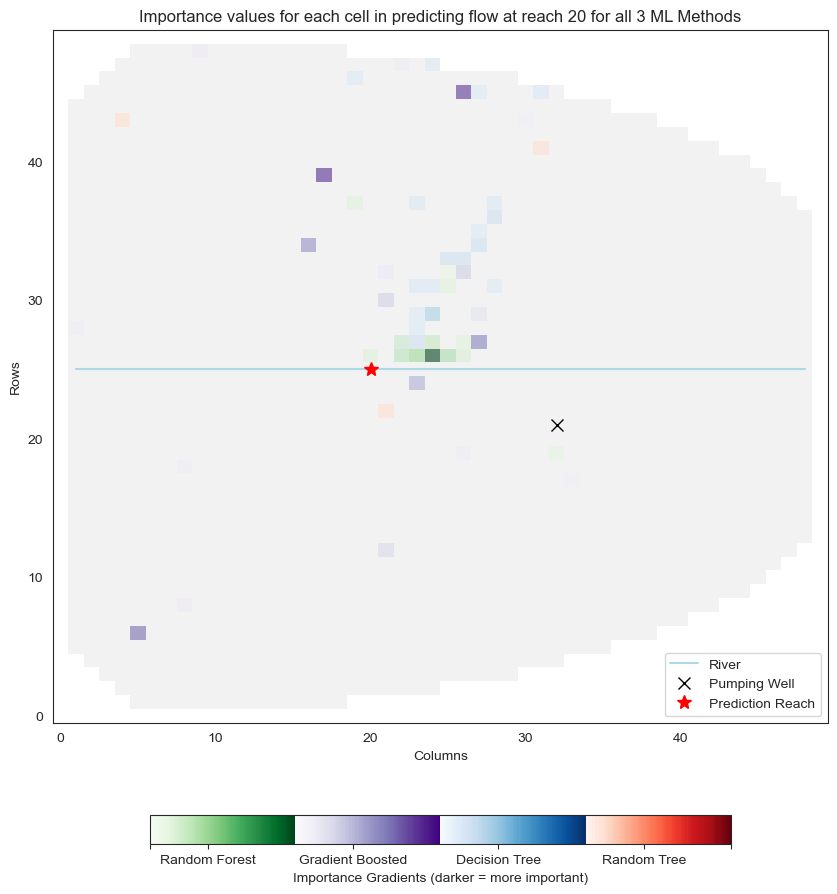

In [116]:
river = np.ndarray((48,))
river[:] = 25

cmap_bd = cm.get_cmap("gray")#,lut=20)
cmap_bd.set_under("w")
cmap_bd.set_over("k")
wellmesh_bd = np.ndarray((50,50))
wellmesh_bd[:,:] = -1e30
for k in range(len(all_well_loc)):
        wellmesh_bd[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = 2

cmap_rf = mp.colormaps.get_cmap("Greens")
wellmesh_rf_masked = np.ma.masked_array(wellmesh_rf, wellmesh_rf < 0.01)

cmap_gr = mp.colormaps.get_cmap("Purples")
wellmesh_gr_masked = np.ma.masked_array(wellmesh_gr, wellmesh_gr < 0.01)

cmap_dt = mp.colormaps.get_cmap("Blues")
wellmesh_dt_masked = np.ma.masked_array(wellmesh_dt, wellmesh_dt < 0.01)

cmap_rand = mp.colormaps.get_cmap("Reds")
wellmesh_rand_masked = np.ma.masked_array(wellmesh_rand, wellmesh_rand < 0.01)

# combine them and build a new colormap
colors = np.vstack((cmap_rf(np.linspace(0.,1,128)), cmap_gr(np.linspace(0.,1,128)), cmap_dt(np.linspace(0.,1,128)),cmap_rand(np.linspace(0.,1,128))))
print(colors)

mymap = mp.colors.LinearSegmentedColormap.from_list('Merged',colors)
fig, axs = plt.subplots(figsize=(10,12))
#plt.figure(figsize=(8,10))
alpha = 0.6
axs.pcolormesh(KK,GG,wellmesh_bd,vmax = vmax, vmin = vmin, cmap = cmap_bd, shading='nearest', alpha = 0.05)
axs.pcolormesh(KK,GG,wellmesh_dt_masked,vmax = vmax, vmin = vmin, cmap = cmap_dt, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Decision Tree", shrink = 0.25, pad = 0.05, anchor = (0,0.25), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_rf_masked,vmax = vmax, vmin = vmin, cmap = cmap_rf, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Random Forest", shrink = 0.25, anchor = (0.3,0.75), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_gr_masked,vmax = vmax, vmin = vmin, cmap = cmap_gr, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Gradient Boosted", shrink = 0.25, anchor = (0.75,1), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_rand_masked,vmax = vmax, vmin = vmin, cmap = cmap_rand, shading='nearest', alpha = alpha)

#plt.colorbar(cmap = mymap, location = 'bottom')


axs.plot(range(1,49),river, color="lightblue", label='River')
axs.plot(32, 21, marker="x", markersize=8, color="Black", linestyle = "None", label="Pumping Well")
axs.plot(rn, 25, marker="*", markersize=10, color="Red", linestyle = "None",label="Prediction Reach")
axs.set_xlabel('Columns')
axs.set_ylabel('Rows')
axs.set_title('Importance values for each cell in predicting flow at reach ' + str(rn) + ' for all 3 ML Methods')
axs.legend(loc="lower right")
#axs[1].axis('off')
cbar = fig.colorbar(mp.cm.ScalarMappable(cmap=mymap), drawedges = False, ax = axs,label = 'Importance Gradients (darker = more important)', orientation = 'horizontal', ticks = [0,0.1,0.35,0.6,0.85,1],pad = 0.1, shrink = 0.75)
cbar.ax.set_xticklabels(['','Random Forest', 'Gradient Boosted','Decision Tree','Random Tree',''])
#plt.legend()

### Trying the Iterative random Forest 

https://github.com/Yu-Group/iterative-Random-Forest/blob/master/demo/03_iRF_demo_Regression.ipynb

In [59]:
#print(all_well_loc)


## Extra plotting code cells

C:\Users\davem\AppData\Local\Temp\ipykernel_10884\1568857108.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_bd = cm.get_cmap("gray")#,lut=20)
C:\Users\davem\AppData\Local\Temp\ipykernel_10884\1568857108.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ch = cm.get_cmap("Paired")#,lut=20)


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

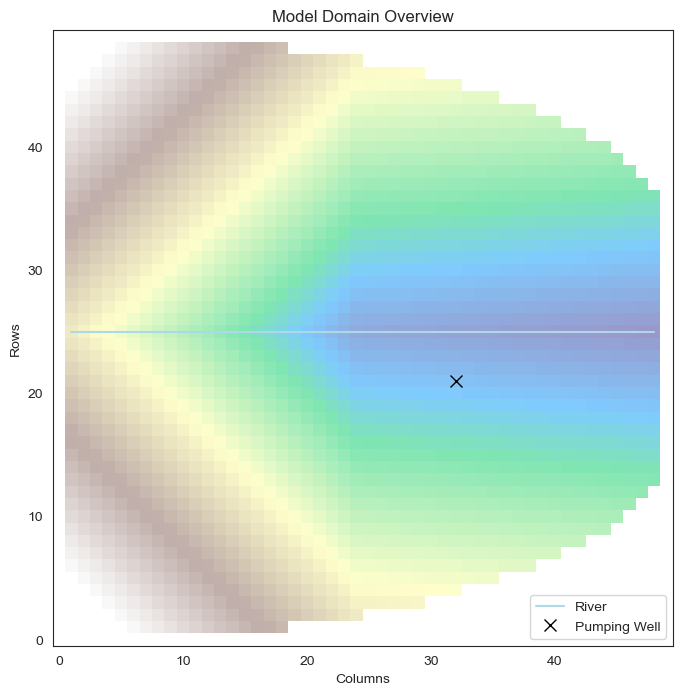

In [86]:
kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)


wellmesh_ztop = np.ndarray((50,50))
wellmesh_ztop[:,:] = 0

for k in range(len(all_well_loc)):
    wellmesh_ztop[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = ztop[int(all_well_loc[k, 0]),int(all_well_loc[k, 1])]
wellmesh_ztop = np.ma.masked_array(wellmesh_ztop, wellmesh_ztop < 0.01)
river = np.ndarray((48,))
river[:] = 25

cmap_bd = cm.get_cmap("gray")#,lut=20)
cmap_bd.set_under("w")
cmap_bd.set_over("k")

cmap_ch = cm.get_cmap("Paired")#,lut=20)
cmap_ch.set_under("w")
#cmap_ch.set_over("k")

wellmesh_bd = np.ndarray((50,50))
wellmesh_bd[:,:] = -1e30
wm_ch = wellmesh_bd.copy()

CHBound_loc = np.where(all_well_loc[:,1] == 48) 
rch_bound = np.where(all_well_loc[:,1] < 10) 
et_bound = np.where(all_well_loc[:,1] >= 10)
#print(CHBound_loc)

for k in range(len(all_well_loc)):
    wellmesh_bd[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = 2

for j in rch_bound[0]:
    wm_ch[int(all_well_loc[j, 1]), int(all_well_loc[j, 0])] = 3
for j in et_bound[0]:
    wm_ch[int(all_well_loc[j, 1]), int(all_well_loc[j, 0])] = 4     
for j in CHBound_loc[0]:
    wm_ch[int(all_well_loc[j, 1]), int(all_well_loc[j, 0])] = 2
wm_ch = np.ma.masked_array(wm_ch, wm_ch < 0.01)

    
fig, axs = plt.subplots(figsize=(8,8))
#plt.figure(figsize=(8,10))
alpha = 0.6
#axs.pcolormesh(KK,GG,wellmesh_bd, cmap = cmap_bd, shading='nearest', alpha = 0.05, ec='grey')
axs.pcolormesh(KK,GG,wellmesh_ztop, cmap = cm.terrain, shading='nearest', alpha = 0.5, ec='None')

#axs.pcolormesh(KK,GG,wm_ch, cmap = cmap_ch, shading='nearest', alpha = 0.5)

axs.plot(range(1,49),river, color="lightblue", label='River')
axs.plot(32, 21, marker="x", markersize=8, color="Black", linestyle = "None", label="Pumping Well")
#axs.plot(rn, 25, marker="*", markersize=10, color="Red", linestyle = "None",label="Prediction Reach")
axs.set_xlabel('Columns')
axs.set_ylabel('Rows')
axs.set_title('Model Domain Overview')
axs.legend(loc="lower right")
plt.colorbar()

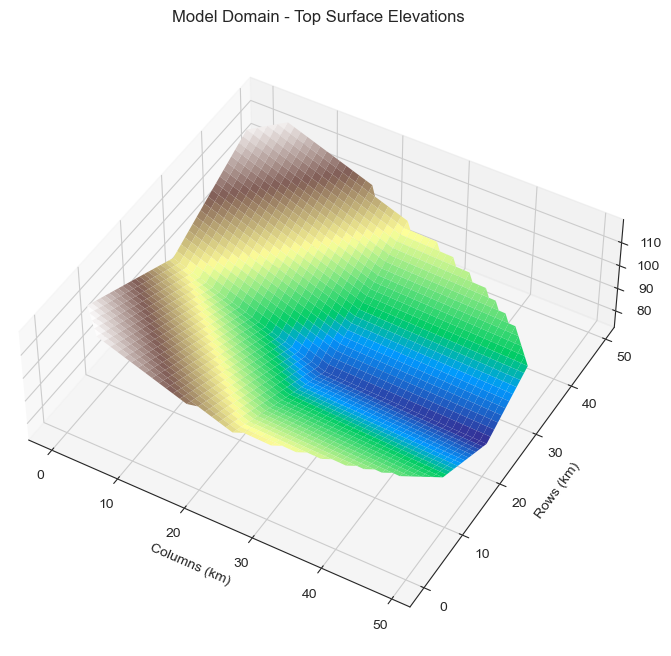

In [79]:

    
axes = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
axes.set_box_aspect([1,1,0.35])
axes.plot_surface(GG, KK, wellmesh_ztop, cmap = cm.terrain, edgecolor='None')
axes.set_title('Model Domain - Top Surface Elevations')
axes.set_xlabel('Columns (km)')
axes.set_ylabel('Rows (km)')
axes.set_zlabel('Elevation (m)')


axes.view_init(45, -50,0)
plt.savefig(r'C:\Users\davem\Documents\Thesis\Topsurface.png')